## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [93]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt

In [94]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Now that we have the object points and image points, we can calibrate the camera.

In [95]:
import pickle
# Do camera calibration given object points and image points
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

#Undistort test image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)


## Now that we have distortion coefficients and camera matrix, we can apply undistortion to the images of the road, but first we will find 4 points corresponding to a square to perform perspective transform, for this I will use some of the code from the first project

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


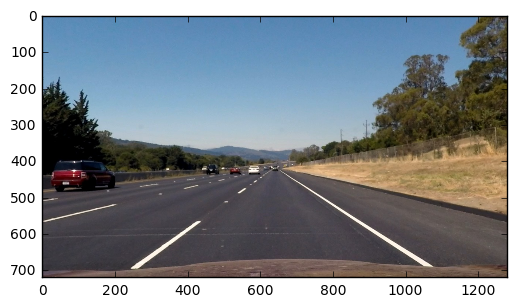

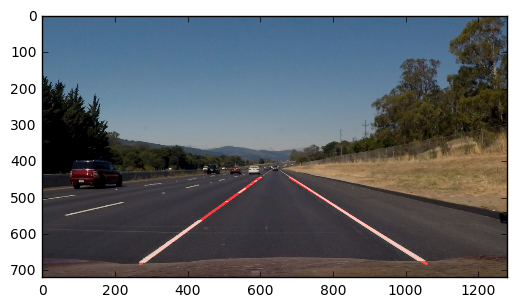

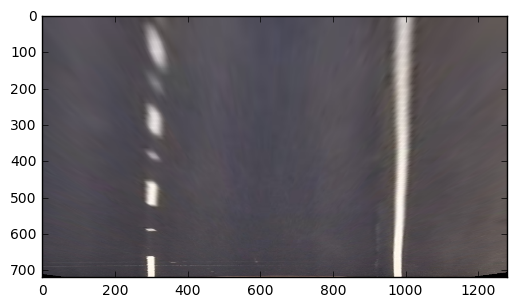

In [194]:
#reading in an image
import matplotlib.image as mpimg
image = mpimg.imread('test_images/straight_lines2.jpg')
img_size = (image.shape[1], image.shape[0])
#undistort image
undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(undistorted_image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
plt.show()


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices, vertices_inner):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    It also takes out the inner region defined by 'vertices_inner'
    """
    #defining blank masks to start with
    mask = np.zeros_like(img)
    mask_inner = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #filling pixels inside the polygon defined by "vertices_inner" with the fill color
    cv2.fillPoly(mask_inner, vertices_inner, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    #returning image after removing the region defined by vertices_inner
    masked_image2 = cv2.bitwise_and((masked_image), (255-mask_inner))
    return masked_image2


def draw_lines(img, lines, y_0, y_1, color=[255, 0, 0], thickness=5):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    
    This functions recieves several lines and classifies them
    between left and right line depending on their slope,
    right line and left line's slope 'm' and 'b' parameter are
    averaged to get a single left and a single right line
    y = mx + b
    """
    line_left_params = np.zeros(3) #vector used to accumulate m, b and number of lines on each side
    line_right_params = np.zeros(3)
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2-y1)/(x2-x1)
            if(m>0.50 or m < -0.50): #ignore lines with slopes not likely to correspond to lanes
                if(m<0):
                    line_left_params[0] = line_left_params[0] + m        #accumulate slope
                    line_left_params[1] = line_left_params[1] + y1-m*x1  #accumulate b
                    line_left_params[2] = line_left_params[2] + 1        #count number of lines
                else:
                    line_right_params[0] = line_right_params[0] + m
                    line_right_params[1] = line_right_params[1] + y1-m*x1
                    line_right_params[2] = line_right_params[2] + 1
    if(line_left_params[2] != 0):  
        line_left_params = line_left_params/line_left_params[2]          #if lines were encountered, average m and b
    if(line_right_params[2] != 0):
        line_right_params = line_right_params/line_right_params[2]

        
    line_left = line_evaluate(line_left_params[0], line_left_params[1], y_0, y_1)   # get x1,y1,x2 and y2 from m and b
    line_right = line_evaluate(line_right_params[0], line_right_params[1], y_0, y_1)
    cv2.line(img, (line_left[0], line_left[1]), (line_left[2], line_left[3]), color, thickness)  #draw both lines
    cv2.line(img, (line_right[0], line_right[1]), (line_right[2]+5, line_right[3]), color, thickness)
    return line_left, line_right
    
    
def line_evaluate(m,b,y1,y0):
    """
    This function takes the parameters: slope 'm', 'b' and the
    y coordinate of the highest and lowest point of the lines
    'y0' and 'y1' to return the points x0, y0, x1 and y1 of the line
    
    """
    if (m==0):
        x0 = 0
        y0 = 0
        x1= 0
        y1 =0
        print("no line found")
    else:
        x0 = (y0-b)/m
        x1 = (y1-b)/m
    try:
        points = np.array([int(x1), int(y1), int(x0), int(y0)])
    except:
        points = np.array([0, 0, 0, 0])
        print("no line found")
    return points
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, y0, y1):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

    #print("number of lines", lines.shape)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    line_left, line_right = draw_lines(line_img, lines, y0, y1)
    return line_img, line_left, line_right
    #except:
    #    print("no lines detected")
    #    return img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

gray = cv2.cvtColor(undistorted_image, cv2.COLOR_RGB2GRAY)
imshape = gray.shape

kernel_size = 5
blur_gray = gaussian_blur(gray,kernel_size)

low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

vertices = np.array([[(0.45*imshape[1],0.62*imshape[0]),(0.02*imshape[1], imshape[0]), (0.98*imshape[1], imshape[0]), (0.55*imshape[1],0.62*imshape[0])]], dtype=np.int32)
vertices_inner = np.array([[(0.5*imshape[1],0.62*imshape[0]),(0.3*imshape[1], imshape[0]), (0.7*imshape[1], imshape[0]), (0.5*imshape[1],0.62*imshape[0])]], dtype=np.int32)    
masked_edges = region_of_interest((edges), vertices, vertices_inner)

rho = 3 # distance resolution in pixels of the Hough grid
theta = 0.5*np.pi/180 # angular resolution in radians of the Hough grid
threshold = 100     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 300 #minimum number of pixels making up a line
max_line_gap =  200  # maximum gap in pixels between connectable line segments
line_image, line_left, line_right = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap, int(0.62*imshape[0]), int(0.95*imshape[0]))
result = weighted_img(line_image, image)

plt.imshow(result)
plt.show()

#Find projection matrix and warp image
margin_h = 100
margin_w = 300
lane_length = 20.0
lane_width = 3.7
#window_length = 30.0
#window_width = 5.0
img_size = (imshape[1], imshape[0])
src = np.float32([[line_left[0],line_left[1]],[line_right[0],line_right[1]],[line_right[2]+5,line_right[3]],[line_left[2],line_left[3]]])
dst = np.float32([[margin_w,margin_h],[image.shape[1]-margin_w,margin_h],[image.shape[1]-margin_w,image.shape[0]],[margin_w,image.shape[0]]])
M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(undistorted_image, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped)
plt.show()




## Now that we have the matrixes we need to perform undistortion and perspective transform, we can do allthe steps to perform the curvature calculation on any of the test images. We start by reading onee of the test images

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


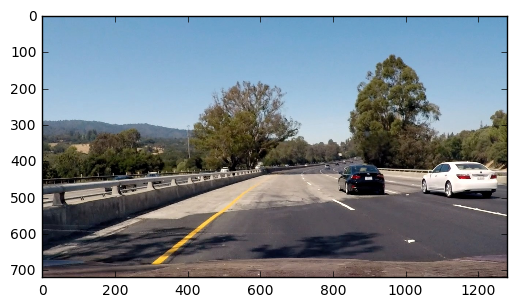

In [195]:
#reading in an image
import matplotlib.image as mpimg
image = mpimg.imread('test_images/test4.jpg')
img_size = (image.shape[1], image.shape[0])
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
plt.show()

## Then we use the coefficients we got above to perform undistortion

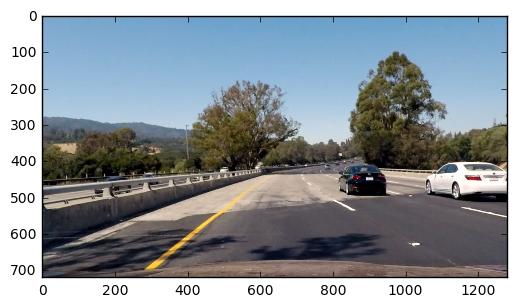

In [196]:
#undistort image
undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
plt.imshow(undistorted_image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
plt.show()

## To have a more clear perception of the image in different color channels I will display the channels of the image in RGB, HSV and HLS

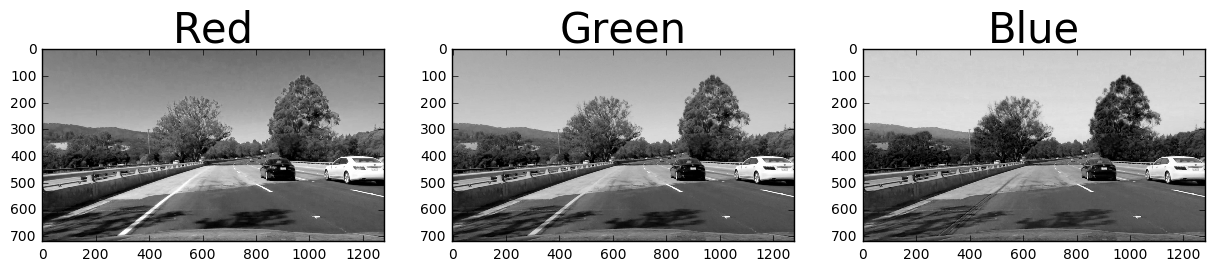

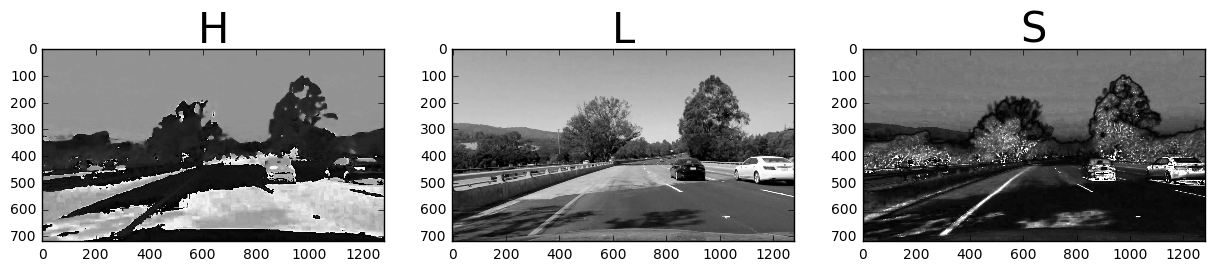

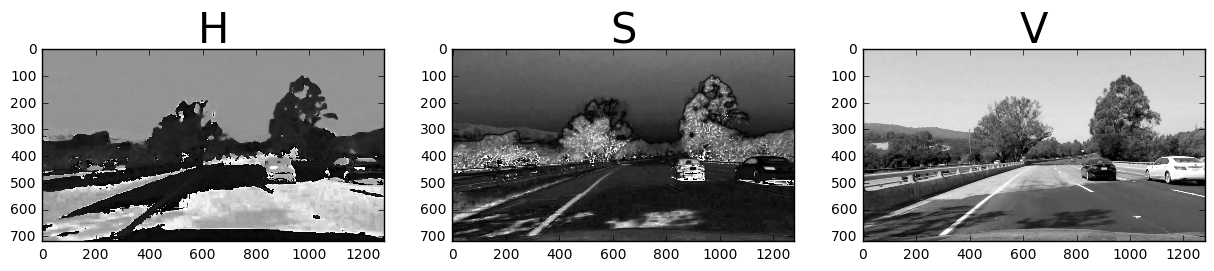

In [197]:
#Visualize images channels in several color spaces
R = undistorted_image[:,:,0]
G = undistorted_image[:,:,1]
B = undistorted_image[:,:,2]
hls = cv2.cvtColor(undistorted_image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]
hsv = cv2.cvtColor(undistorted_image, cv2.COLOR_RGB2HSV)
H2 = hsv[:,:,0]
S2 = hsv[:,:,1]
V = hsv[:,:,2]

# Visualize color spaces
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,8))
ax1.imshow(R, cmap='gray')
ax1.set_title('Red', fontsize=30)
ax2.imshow(G, cmap='gray')
ax2.set_title('Green', fontsize=30)
ax3.imshow(B, cmap='gray')
ax3.set_title('Blue', fontsize=30)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,8))
ax1.imshow(H, cmap='gray')
ax1.set_title('H', fontsize=30)
ax2.imshow(L, cmap='gray')
ax2.set_title('L', fontsize=30)
ax3.imshow(S, cmap='gray')
ax3.set_title('S', fontsize=30)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,8))
ax1.imshow(H2, cmap='gray')
ax1.set_title('H', fontsize=30)
ax2.imshow(S2, cmap='gray')
ax2.set_title('S', fontsize=30)
ax3.imshow(V, cmap='gray')
ax3.set_title('V', fontsize=30)
plt.show()

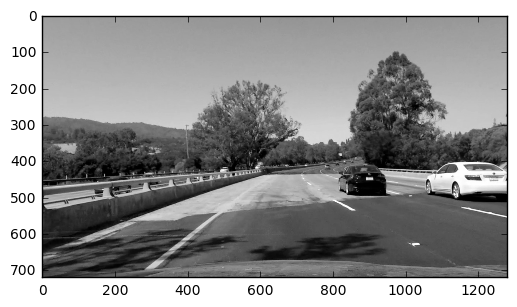

In [198]:
gray = cv2.cvtColor(undistorted_image, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')
plt.show()

## Now, I will use some of the tools learned from the lesson to threshold the images by their color and gradient, displaying all of the binary images from the channels, to try to see which would be the better combination of gradient and color threshold and on which channel.

In [199]:
#Functions to apply gradient thresholding
def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh=(50, 100)):
    
    # Apply the following steps to img
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if(orient == 'x'):
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # 2) Take the gradient in x and y separately
    sobelX = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    sobel = pow((pow(sobelX,2) + pow(sobelY,2)),1/2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # 5) Create a binary mask where mag thresholds are met
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sbinary

def dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3)):
    
    # 2) Take the gradient in x and y separately
    sobelX = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelX)
    abs_sobely = np.absolute(sobelY)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_gradient = np.arctan2(abs_sobely, abs_sobelx) 
    # 5) Create a binary mask where direction thresholds are met
    sbinary = np.zeros_like(dir_gradient)
    sbinary[(dir_gradient >= thresh[0]) & (dir_gradient <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sbinary

def color_threshold(img, s_thresh=(170, 255)):
    # Threshold color channel
    s_binary = np.zeros_like(img)
    s_binary[(img >= s_thresh[0]) & (img <= s_thresh[1])] = 1
    return s_binary

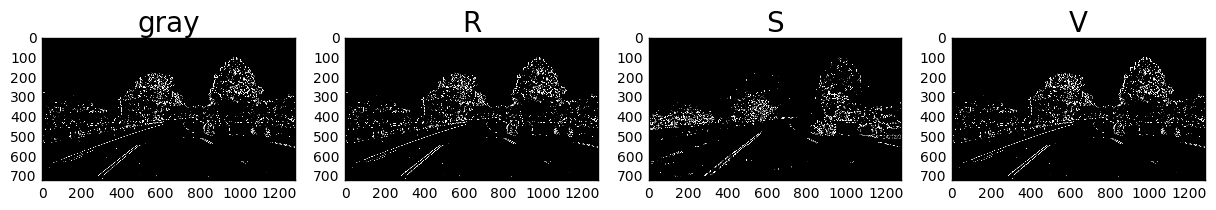

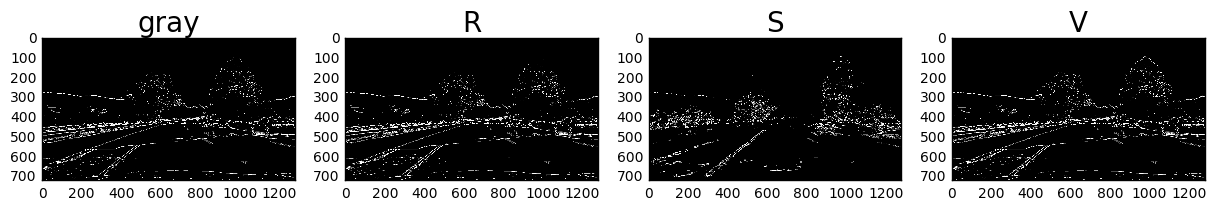

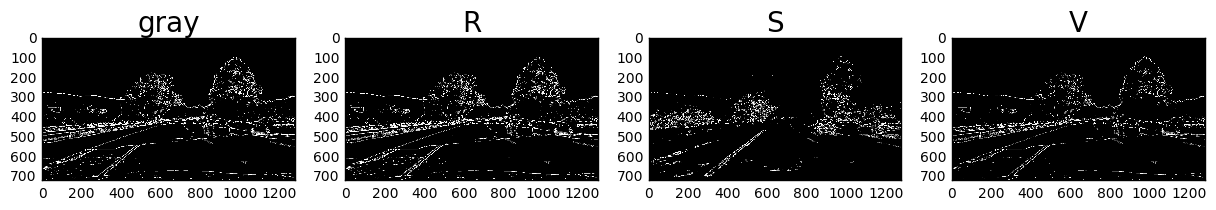

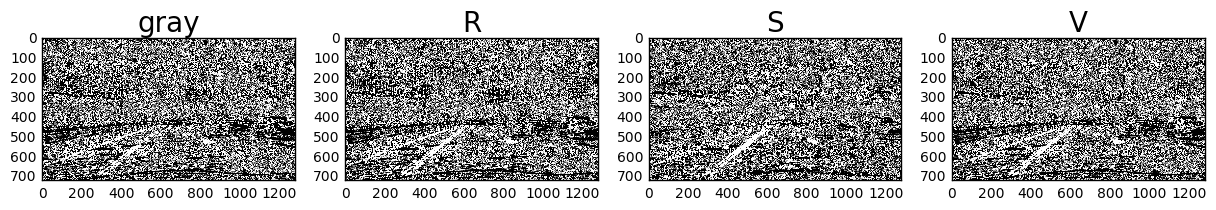

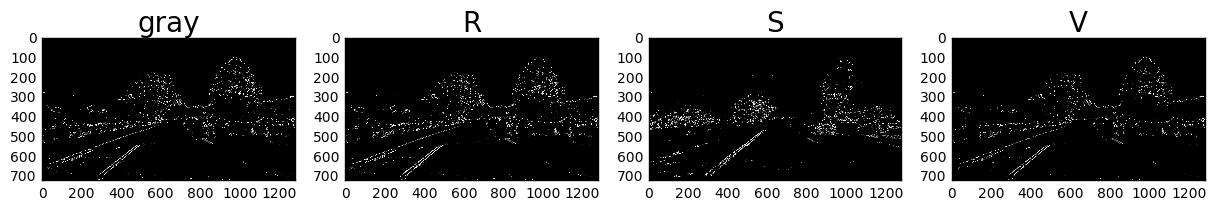

In [200]:
#x edges
gray_sobelX = abs_sobel_thresh(gray, orient='x', thresh=(30, 100))
R_sobelX = abs_sobel_thresh(R, orient='x', thresh=(30, 100))
S_sobelX = abs_sobel_thresh(S, orient='x', thresh=(30, 100))
V_sobelX = abs_sobel_thresh(V, orient='x', thresh=(30, 100))

#y edges
gray_sobelY = abs_sobel_thresh(gray, orient='y', thresh=(40, 100))
R_sobelY = abs_sobel_thresh(R, orient='y', thresh=(40, 100))
S_sobelY = abs_sobel_thresh(S, orient='y', thresh=(40, 100))
V_sobelY = abs_sobel_thresh(V, orient='y', thresh=(40, 100))

#xy edges
gray_sobelXY = mag_thresh(gray, mag_thresh=(40, 100))
R_sobelXY = mag_thresh(R, mag_thresh=(40, 100))
S_sobelXY = mag_thresh(S, mag_thresh=(40, 100))
V_sobelXY = mag_thresh(V, mag_thresh=(50, 100))

#dir edges
gray_sobelDir = dir_threshold(gray, thresh=(0.5, 1.3))
R_sobelDir = dir_threshold(R, thresh=(0.5, 1.3))
S_sobelDir = dir_threshold(S, thresh=(0.5, 1.3))
V_sobelDir = dir_threshold(V, thresh=(0.5, 1.3))

#combined
gray_combined = np.zeros_like(gray)
gray_combined[((gray_sobelX == 1) & (gray_sobelY == 1)) | ((gray_sobelXY == 1) & (gray_sobelDir == 1))] = 1

R_combined = np.zeros_like(gray)
R_combined[((R_sobelX == 1) & (R_sobelY == 1)) | ((R_sobelXY == 1) & (R_sobelDir == 1))] = 1

S_combined = np.zeros_like(gray)
S_combined[((S_sobelX == 1) & (S_sobelY == 1)) | ((S_sobelXY == 1) & (S_sobelDir == 1))] = 1

V_combined = np.zeros_like(gray)
V_combined[((V_sobelX == 1) & (V_sobelY == 1)) | ((V_sobelXY == 1) & (V_sobelDir == 1))] = 1

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,8))
ax1.imshow(gray_sobelX, cmap='gray')
ax1.set_title('gray', fontsize=20)
ax2.imshow(R_sobelX, cmap='gray')
ax2.set_title('R', fontsize=20)
ax3.imshow(S_sobelX, cmap='gray')
ax3.set_title('S', fontsize=20)
ax4.imshow(V_sobelX, cmap='gray')
ax4.set_title('V', fontsize=20)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,8))
ax1.imshow(gray_sobelY, cmap='gray')
ax1.set_title('gray', fontsize=20)
ax2.imshow(R_sobelY, cmap='gray')
ax2.set_title('R', fontsize=20)
ax3.imshow(S_sobelY, cmap='gray')
ax3.set_title('S', fontsize=20)
ax4.imshow(V_sobelY, cmap='gray')
ax4.set_title('V', fontsize=20)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,8))
ax1.imshow(gray_sobelXY, cmap='gray')
ax1.set_title('gray', fontsize=20)
ax2.imshow(R_sobelXY, cmap='gray')
ax2.set_title('R', fontsize=20)
ax3.imshow(S_sobelXY, cmap='gray')
ax3.set_title('S', fontsize=20)
ax4.imshow(V_sobelXY, cmap='gray')
ax4.set_title('V', fontsize=20)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,8))
ax1.imshow(gray_sobelDir, cmap='gray')
ax1.set_title('gray', fontsize=20)
ax2.imshow(R_sobelDir, cmap='gray')
ax2.set_title('R', fontsize=20)
ax3.imshow(S_sobelDir, cmap='gray')
ax3.set_title('S', fontsize=20)
ax4.imshow(V_sobelDir, cmap='gray')
ax4.set_title('V', fontsize=20)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,8))
ax1.imshow(gray_combined, cmap='gray')
ax1.set_title('gray', fontsize=20)
ax2.imshow(R_combined, cmap='gray')
ax2.set_title('R', fontsize=20)
ax3.imshow(S_combined, cmap='gray')
ax3.set_title('S', fontsize=20)
ax4.imshow(V_combined, cmap='gray')
ax4.set_title('V', fontsize=20)
plt.show()

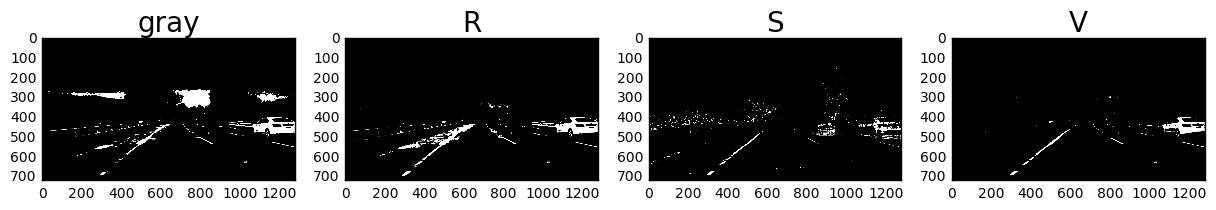

In [201]:
#SCombined
#Color Threshold
#dir edges
gray_color = color_threshold(gray, s_thresh=(200, 255))
R_color = color_threshold(R, s_thresh=(210, 255))
S_color = color_threshold(S, s_thresh=(200, 255))
V_color = color_threshold(V, s_thresh=(230, 255))

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,8))
ax1.imshow(gray_color, cmap='gray')
ax1.set_title('gray', fontsize=20)
ax2.imshow(R_color, cmap='gray')
ax2.set_title('R', fontsize=20)
ax3.imshow(S_color, cmap='gray')
ax3.set_title('S', fontsize=20)
ax4.imshow(V_color, cmap='gray')
ax4.set_title('V', fontsize=20)
plt.show()

## Now that we have gradient and color thresholded binary images, we can combine them toi get a better representation of the lane lines

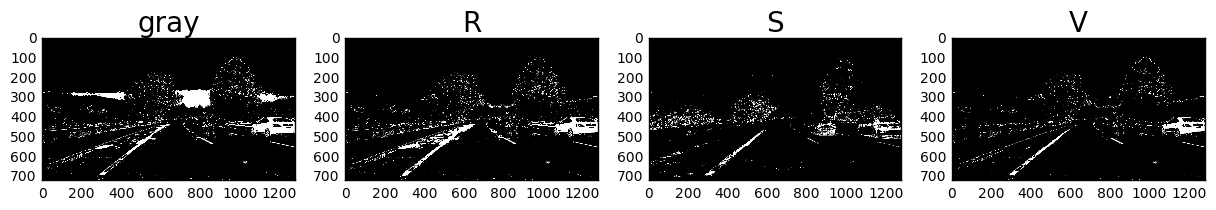

In [202]:
#combine color and gradient
gray_combined2 = np.zeros_like(gray)
gray_combined2[(gray_combined == 1) | (gray_color == 1)] = 1

R_combined2 = np.zeros_like(gray)
R_combined2[(R_combined == 1) | (R_color == 1)] = 1

S_combined2 = np.zeros_like(gray)
S_combined2[(S_combined == 1) | (S_color == 1)] = 1

V_combined2 = np.zeros_like(gray)
V_combined2[(V_combined == 1) | (V_color == 1)] = 1

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,8))
ax1.imshow(gray_combined2, cmap='gray')
ax1.set_title('gray', fontsize=20)
ax2.imshow(R_combined2, cmap='gray')
ax2.set_title('R', fontsize=20)
ax3.imshow(S_combined2, cmap='gray')
ax3.set_title('S', fontsize=20)
ax4.imshow(V_combined2, cmap='gray')
ax4.set_title('V', fontsize=20)
plt.show()

## Now, using the transformation matrix, I transform the perspective to get a bird view

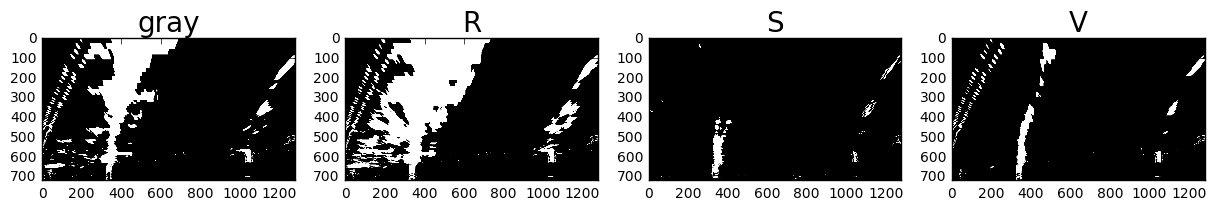

In [203]:
#Choose S channel
#Perspective Transformation
gray_warped = cv2.warpPerspective(gray_combined2, M, img_size, flags=cv2.INTER_LINEAR)
R_warped = cv2.warpPerspective(R_combined2, M, img_size, flags=cv2.INTER_LINEAR)
S_warped = cv2.warpPerspective(S_combined2, M, img_size, flags=cv2.INTER_LINEAR)
V_warped = cv2.warpPerspective(V_combined2, M, img_size, flags=cv2.INTER_LINEAR)

warped = np.copy(V_warped)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,8))
ax1.imshow(gray_warped, cmap='gray')
ax1.set_title('gray', fontsize=20)
ax2.imshow(R_warped, cmap='gray')
ax2.set_title('R', fontsize=20)
ax3.imshow(S_warped, cmap='gray')
ax3.set_title('S', fontsize=20)
ax4.imshow(V_warped, cmap='gray')
ax4.set_title('V', fontsize=20)
plt.show()

## After seeing that the S channel outputs the most consistent results, we wil define a function to get a binary warped image using this color channel

In [204]:
def get_warped_binary_S(img):
    #undistort image
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    #change to hls color space
    hls_img = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2HLS)
    S_img = hls_img[:,:,2]
    #x edges
    S_sobel_X = abs_sobel_thresh(S_img, orient='x', thresh=(30, 100))
    S_sobel_Y = abs_sobel_thresh(S_img, orient='y', thresh=(40, 100))
    #xy edges
    S_sobel_XY = mag_thresh(S_img, mag_thresh=(40, 100))
    #dir edges
    S_sobel_Dir = dir_threshold(S_img, thresh=(0.5, 1.3))
    #combined
    S_comb = np.zeros_like(S_img)
    S_comb[((S_sobel_X == 1) & (S_sobel_Y == 1)) | ((S_sobel_XY == 1) & (S_sobel_Dir == 1))] = 1
    #Color thresh
    S_col = color_threshold(S_img, s_thresh=(170, 255))
    #Combine colors and gradient
    S_combined_2 = np.zeros_like(S_img)
    S_combined_2[(S_comb == 1) | (S_col == 1)] = 1
    #Perspective transform
    warped_binary2 = cv2.warpPerspective(S_combined_2, M, img_size, flags=cv2.INTER_LINEAR)
    return warped_binary2

def get_warped_binary_V(img):
    #undistort image
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    #change to hls color space
    hsv_img = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2HSV)
    V_img = hsv_img[:,:,2]
    V_img_blur = cv2.GaussianBlur(V_img, (5, 5), 0)
    #x edges
    V_sobel_X = abs_sobel_thresh(V_img, orient='x', thresh=(30, 100))
    V_sobel_Y = abs_sobel_thresh(V_img, orient='y', thresh=(40, 100))
    #xy edges
    V_sobel_XY = mag_thresh(V_img, mag_thresh=(50, 100))
    #dir edges
    V_sobel_Dir = dir_threshold(V_img, thresh=(0.5, 1.3))
    #combined
    V_comb = np.zeros_like(V_img)
    V_comb[((V_sobel_X == 1) & (V_sobel_Y == 1)) | ((V_sobel_XY == 1) & (V_sobel_Dir == 1))] = 1
    #Color thresh
    V_col = color_threshold(V_img, s_thresh=(230, 255))
    #Combine colors and gradient
    V_combined_2 = np.zeros_like(V_img)
    V_combined_2[(V_comb == 1) | (V_col == 1)] = 1
       
    #Perspective transform
    warped_binary2 = cv2.warpPerspective(V_combined_2, M, img_size, flags=cv2.INTER_LINEAR)
    #perform openning morfological operation
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    opening = cv2.morphologyEx(warped_binary2, cv2.MORPH_OPEN, kernel) 
    return opening
    

## Now that we can get a binary warped image, it's time to calculate the lines and their curvature

In [205]:
def measure_curvature_real(left_fit,right_fit,ploty):
    '''
    Calculates the curvature o
    f polynomial functions in meters.
    '''
    ym_per_pix = 30/600 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)-100 * ym_per_pix
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

#Functions to Fit a 2nd order polynom to the binary warped image
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 200
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = int(leftx_current - margin/2) # Update this
        win_xleft_high = int(leftx_current + margin/2)  # Update this
        win_xright_low = int(rightx_current - margin/2)  # Update this
        win_xright_high = int(rightx_current + margin/2)  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if(len(good_left_inds) > minpix):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, drawEnable = False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    if(drawEnable):
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit, ploty


def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def search_around_poly(binary_warped, left_fit, right_fit, drawEnable = False):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    if(drawEnable):
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fit, right_fit, ploty

def draw_area(img, left_fit, right_fit, ploty):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result


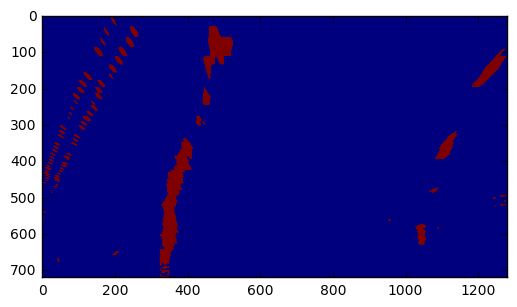

In [206]:
binary_warped1 = get_warped_binary_V(image)
plt.imshow(binary_warped1)
plt.show()

## We can calculate the lines for the first warped image

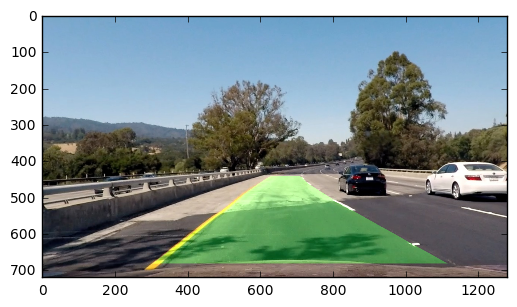

In [207]:
#Fit polynom
out_img, left_fit, right_fit, ploty = fit_polynomial(binary_warped1)
out1 = draw_area(image, left_fit, right_fit, ploty)
plt.imshow(out1)
plt.show()

## With an initial line detection, we should be able to perform a second detection based on the previous lines for a next image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


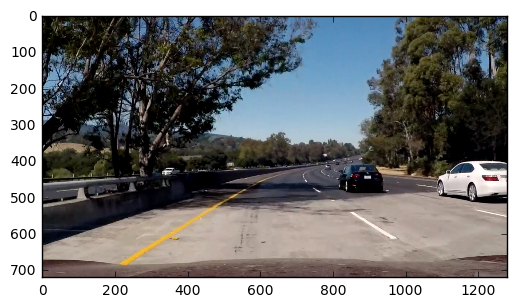

In [208]:
#read a new image
import matplotlib.image as mpimg
image2 = mpimg.imread('test_images/test5.jpg')
img_size = (image2.shape[1], image.shape[0])
#printing out some stats and plotting
print('This image is:', type(image2), 'with dimensions:', image2.shape)
plt.imshow(image2)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
plt.show()

In [209]:
binary_warped2 = get_warped_binary_V(image2)
#plt.imshow(binary_warped2, cmap='gray')
#result = search_around_poly(binary_warped)

# # Calculate polynom for second image

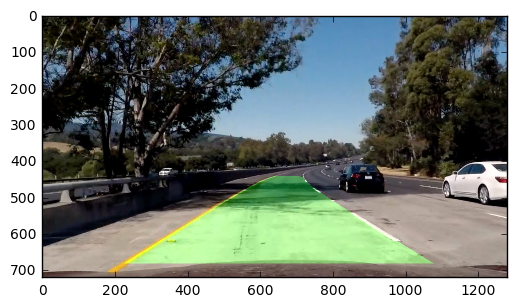

In [210]:
out_img, left_fit, right_fit, ploty = search_around_poly(binary_warped2, left_fit, right_fit)
out2 = draw_area(image2, left_fit, right_fit, ploty)
plt.imshow(out2)
plt.show()

## Now, we calculate curvature, using the formula for a second order polynom

In [212]:
left_curverad, right_curverad = measure_curvature_real(left_fit,right_fit,ploty)
print(left_curverad, 'm', right_curverad, 'm')

963.94322735 m 802.719100169 m


# Now We can test the stack on the videos

In [213]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [214]:
# Define a class to receive the characteristics of each line detection
class Lines():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.ploty = None

In [215]:
firsImage = True 
lane_left = Lines()
lane_right = Lines()

In [219]:

def advanced_process_image(img):
    global lane_left
    global lane_right
    binary_warped = get_warped_binary_V(img)
    if(lane_left.detected and lane_right.detected):
        out, lane_left.best_fit, lane_right.best_fit, lane_left.ploty = search_around_poly(binary_warped, lane_left.best_fit, lane_right.best_fit)
    else:
        out, lane_left.best_fit, lane_right.best_fit, lane_left.ploty = fit_polynomial(binary_warped)
        lane_left.detected = True
        lane_right.detected = True
    result = draw_area(img, lane_left.best_fit, lane_right.best_fit, lane_left.ploty)
    return result
    
    

In [222]:
output_video = 'output_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
lane_left.detected = False
lane_right.detected = False
clip1 = VideoFileClip("examples/project_video.mp4")
firsImage = True 
white_clip = clip1.fl_image(advanced_process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4



100%|█████████▉| 1260/1261 [06:41<00:00,  3.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

CPU times: user 24min 26s, sys: 3min 8s, total: 27min 35s
Wall time: 6min 42s


In [223]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))